In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
scores_dict = pd.read_csv('C:/Users/Gabriel/Documents/MIE368/Data/season_data.csv')
playoff_scores_dict = pd.read_csv('C:/Users/Gabriel/Documents/MIE368/Data/playoff_data.csv')

In [3]:
scores_dict.head()

,Date,Visitor,G_Vis,Home,G_Home,OT Ind,Season
0,2000-10-04,Colorado Avalanche,2.0,Dallas Stars,2.0,1,2001
1,2000-10-05,Ottawa Senators,4.0,Boston Bruins,4.0,1,2001
2,2000-10-05,Chicago Blackhawks,2.0,Buffalo Sabres,4.0,0,2001
3,2000-10-05,Detroit Red Wings,4.0,Calgary Flames,3.0,0,2001
4,2000-10-05,Vancouver Canucks,3.0,Philadelphia Flyers,6.0,0,2001


## Game Result Elo Adjustment

In [5]:
first_yr = scores_dict[scores_dict['Season'] == 2001]
Teams = first_yr['Home'].unique().tolist()

team_changes = {
    'Atlanta Thrashers': 'Winnipeg Jets',
    'Phoenix Coyotes': 'Arizona Coyotes',
    'Mighty Ducks of Anaheim': 'Anaheim Ducks'
    # Add more mappings as needed
}

elo_ratings = {}

K = 6

In [6]:
def calculate_prob_winning(home_team, away_team):
    
    Elo_diff_home = elo_ratings[home_team]-elo_ratings[away_team] + 50  #add extra for home-ice advantage   
    #Elo_diff_away = elo_ratings[away_team] - elo_ratings[home_team]
    prob_win_home = 1/(10**(-1*Elo_diff_home/400)+1)
    #prob_win_away = 1/(10**(-1*Elo_diff_away/400)+1)
    prob_win_away = 1 - prob_win_home
    
    return prob_win_home, prob_win_away, Elo_diff_home

In [7]:
def margin_of_victory(home_goals, away_goals):
    
    mov = abs(home_goals - away_goals)
    mov_mult = 0.6686*np.log(mov)+0.8048
    
    return mov_mult

In [8]:
# Function to update ELO ratings after a game -- Could add input for elo_ratings dictionary 
def update_elo(home_team, away_team, home_goals, away_goals, season, df, idx):
    
    # Map old team names to new ones
    home_team = team_changes.get(home_team, home_team)
    away_team = team_changes.get(away_team, away_team)
    
    #print('Home team is ' + str(home_team))
    #print('Away team is ' + str(away_team))

    if home_team not in elo_ratings:
        # New teams added past a certain year start with a different ELO rating
        elo_ratings[home_team] = 1490 if season >= 2005 else 1380
    if away_team not in elo_ratings:
        elo_ratings[away_team] = 1490 if season >= 2005 else 1380

     # Calculate the probability of winning the game for each team
    home_prob, away_prob, Elo_diff_home = calculate_prob_winning(home_team, away_team)
    
    # Update DataFrame values
    df.at[idx, 'EloDiffHome'] = Elo_diff_home
    df.at[idx, 'EloDiffAway'] = -1 * Elo_diff_home
    df.at[idx, 'WinProbHome'] = home_prob
    df.at[idx, 'WinProbVis'] = away_prob
    
     # Update Pregame Favorite Multiplier
    if home_goals > away_goals:
        home_win = 1
        #away_win = 0
        winner_elo_diff = Elo_diff_home
    elif home_goals < away_goals:
        home_win = 0
        #away_win = 1
        winner_elo_diff = -1*Elo_diff_home
    else:
        return
    
    pre_g_fav_h = home_win - home_prob  
    #pre_g_fav_a = away_win - away_prob  
    
    auto_corr = 2.05/(winner_elo_diff*0.001 + 2.05)
    
     # Adjust ELO shift for margin of victory
    mov_multiplier = auto_corr * margin_of_victory(home_goals, away_goals)
    #print('home goals:' + str(home_goals))
    #print('away goals:' + str(away_goals))
    #print('mult is: ' + str(mov_multiplier))
    
     # Calculate ELO shift based on game result
    elo_shift_h = K * mov_multiplier * pre_g_fav_h 
    #elo_shift_a = K * mov_multiplier * pre_g_fav_a
    #print('elo shift is: ' + str(elo_shift_h))
    
    elo_ratings[home_team] += elo_shift_h
    elo_ratings[away_team] -= elo_shift_h

    #if (home_team == 'Nashville Predators') or (away_team == 'Nashville Predators'):
     #   print(elo_shift_h)
      #  print(elo_ratings['Nashville Predators'])
    #print("Home team elo is: " + str(elo_ratings[home_team]))
    #print("Away team elo is: " + str(elo_ratings[away_team]))

### Testing Game Result Elo Adjustments

In [195]:
'''
elo_ratings = {}
# Iterate over seasons and games
for idx, row in scores_dict.iterrows():
    update_elo(row['Home'], row['Visitor'], row['G_Home'], row['G_Vis'], row['Season'], scores_dict, idx)

truncated_dict = {k: round(v, 2) for k, v in elo_ratings.items()}
print(truncated_dict)
'''

"\nelo_ratings = {}\n# Iterate over seasons and games\nfor idx, row in scores_dict.iterrows():\n    update_elo(row['Home'], row['Visitor'], row['G_Home'], row['G_Vis'], row['Season'], scores_dict, idx)\n\ntruncated_dict = {k: round(v, 2) for k, v in elo_ratings.items()}\nprint(truncated_dict)\n"

In [196]:
'''
elo_ratings = {}
# For testing on one season
for idx, row in scores_dict.iterrows():
    if row['Season'] == 2001:
        update_elo(row['Home'], row['Visitor'], row['G_Home'], row['G_Vis'], row['Season'], scores_dict, idx)

print(elo_ratings)
'''

"\nelo_ratings = {}\n# For testing on one season\nfor idx, row in scores_dict.iterrows():\n    if row['Season'] == 2001:\n        update_elo(row['Home'], row['Visitor'], row['G_Home'], row['G_Vis'], row['Season'], scores_dict, idx)\n\nprint(elo_ratings)\n"

## End of Season Elo Adjustments

In [9]:
# Initialize variables to store the final Elo ratings for the season
final_elo_ratings = {}
elo_ratings = {}
season_weight = 0.7
average_weight = 0.3
current_season = None

# Iterate over seasons and games
for idx, row in scores_dict.iterrows():
    if current_season is None:
        current_season = row['Season']
    
    # Check if the season in the current row is different from the current season
    if row['Season'] != current_season:
        # Save the previous season's Elo ratings and calculate the starting Elo for the new season
        final_elo_ratings[current_season] = dict(elo_ratings)
        elo_ratings = {}  # Reset Elo ratings for the new season

        for team in final_elo_ratings[current_season]:
            prev_season_elo = final_elo_ratings[current_season][team]
            league_avg_elo = sum(final_elo_ratings[current_season].values()) / len(final_elo_ratings[current_season])
            starting_elo = (season_weight * prev_season_elo) + (average_weight * league_avg_elo)
            elo_ratings[team] = round(starting_elo, 2)

        current_season = row['Season']


    # Update Elo ratings for the game
    update_elo(row['Home'], row['Visitor'], row['G_Home'], row['G_Vis'], row['Season'], scores_dict, idx)

# Calculate the final Elo ratings for the last season
final_elo_ratings[current_season] = dict(elo_ratings)

In [198]:
elo_ratings

{'Dallas Stars': 1438.449568876547,
 'Colorado Avalanche': 1467.0041326779394,
 'Boston Bruins': 1530.397215501669,
 'Ottawa Senators': 1365.1050381874425,
 'Buffalo Sabres': 1373.1864106169082,
 'Chicago Blackhawks': 1280.4201757826659,
 'Calgary Flames': 1402.1947282646518,
 'Detroit Red Wings': 1329.8577019700033,
 'Philadelphia Flyers': 1307.0972745553063,
 'Vancouver Canucks': 1370.2816315577088,
 'Arizona Coyotes': 1289.5863386862557,
 'St. Louis Blues': 1371.011391435606,
 'Edmonton Oilers': 1468.3836695037394,
 'Florida Panthers': 1425.486802121703,
 'Anaheim Ducks': 1255.6070111408524,
 'Minnesota Wild': 1431.4151312241875,
 'New Jersey Devils': 1419.86898941051,
 'Montreal Canadiens': 1294.8165146511856,
 'Pittsburgh Penguins': 1392.0652070159683,
 'Nashville Predators': 1392.4566649394321,
 'San Jose Sharks': 1272.6965553339462,
 'Tampa Bay Lightning': 1427.353379517724,
 'New York Islanders': 1399.2857789281184,
 'Washington Capitals': 1362.2730179203713,
 'Los Angeles King

### Testing End of Season Adjustments

In [46]:
#first_2_yrs = scores_dict[scores_dict['Season'] < 2003]

In [47]:
'''
elo_ratings = {}
final_elo_ratings = {}
season_weight = 0.7
average_weight = 0.3
current_season = None
'''

'\nelo_ratings = {}\nfinal_elo_ratings = {}\nseason_weight = 0.7\naverage_weight = 0.3\ncurrent_season = None\n'

In [48]:
'''
# Iterate over seasons and games
for idx, row in first_2_yrs.iterrows():
    if current_season is None:
        current_season = row['Season']
        print('initialize season ' + str(current_season))
    
    # Check if the season in the current row is different from the current season
    if row['Season'] != current_season:
        print('new season: ' + str(row['Season']))
        # Save the previous season's Elo ratings and calculate the starting Elo for the new season
        final_elo_ratings[current_season] = dict(elo_ratings)
        print(f'season end game elo\n{final_elo_ratings[current_season]}')
        elo_ratings = {}  # Reset Elo ratings for the new season

        for team in final_elo_ratings[current_season]:
            prev_season_elo = final_elo_ratings[current_season][team]
            print(prev_season_elo)
            league_avg_elo = sum(final_elo_ratings[current_season].values()) / len(final_elo_ratings[current_season])
            starting_elo = (season_weight * prev_season_elo) + (average_weight * league_avg_elo)
            elo_ratings[team] = round(starting_elo, 2)
            print(f'next season start elo\n{elo_ratings}')
            
        current_season = row['Season']
        print('update current season: ' + str(current_season))
    
    # Update Elo ratings for the game
    update_elo(row['Home'], row['Visitor'], row['G_Home'], row['G_Vis'], row['Season'], first_2_yrs, idx)
              
# Calculate the final Elo ratings for the last season
final_elo_ratings[current_season] = dict(elo_ratings)
'''

"\n# Iterate over seasons and games\nfor idx, row in first_2_yrs.iterrows():\n    if current_season is None:\n        current_season = row['Season']\n        print('initialize season ' + str(current_season))\n    \n    # Check if the season in the current row is different from the current season\n    if row['Season'] != current_season:\n        print('new season: ' + str(row['Season']))\n        # Save the previous season's Elo ratings and calculate the starting Elo for the new season\n        final_elo_ratings[current_season] = dict(elo_ratings)\n        print(f'season end game elo\n{final_elo_ratings[current_season]}')\n        elo_ratings = {}  # Reset Elo ratings for the new season\n\n        for team in final_elo_ratings[current_season]:\n            prev_season_elo = final_elo_ratings[current_season][team]\n            print(prev_season_elo)\n            league_avg_elo = sum(final_elo_ratings[current_season].values()) / len(final_elo_ratings[current_season])\n            starting

In [49]:
#first_2_yrs

## Regression Models for Scoring

In [50]:
#def df_elodiff_add(row):
#    home_prob, away_prob, Elo_diff_home = calculate_prob_winning(row['Home'], row['Visitor'], row['G_Home'], row['G_Vis'])
#    row['EloDiffHome'] = Elo_diff_home
#    row['EloDiffAway'] = -1*Elo_diff_home

In [12]:
scores_dict.head()

,Date,Visitor,G_Vis,Home,G_Home,OT Ind,Season,EloDiffHome,EloDiffAway,WinProbHome,WinProbVis
0,2000-10-04,Colorado Avalanche,2.0,Dallas Stars,2.0,1,2001,50.0,-50.0,0.571463,0.428537
1,2000-10-05,Ottawa Senators,4.0,Boston Bruins,4.0,1,2001,50.0,-50.0,0.571463,0.428537
2,2000-10-05,Chicago Blackhawks,2.0,Buffalo Sabres,4.0,0,2001,50.0,-50.0,0.571463,0.428537
3,2000-10-05,Detroit Red Wings,4.0,Calgary Flames,3.0,0,2001,50.0,-50.0,0.571463,0.428537
4,2000-10-05,Vancouver Canucks,3.0,Philadelphia Flyers,6.0,0,2001,50.0,-50.0,0.571463,0.428537


In [13]:
# Define features to remove from the feature data (i.e., X)
drop_for_X_H = ['Date','Visitor','Home','OT Ind', 'G_Vis', 'EloDiffAway', 'WinProbVis', 'Season']
drop_for_X_V = ['Date','Visitor','Home','OT Ind', 'G_Home', 'EloDiffHome', 'WinProbHome', 'Season']

home_split = scores_dict.drop(columns=drop_for_X_H)
away_split = scores_dict.drop(columns=drop_for_X_V)

home_split.columns = [None] * len(home_split.columns)
away_split.columns = [None] * len(away_split.columns)

# Concatenate DataFrames
goals_elo_df = pd.concat([home_split, away_split], ignore_index=True)

col_names = ['Goals', 'EloDiff', 'WinProb']
goals_elo_df.columns = col_names

In [14]:
goals_elo_df.head()

,Goals,EloDiff,WinProb
0,2.0,50.0,0.571463
1,4.0,50.0,0.571463
2,4.0,50.0,0.571463
3,3.0,50.0,0.571463
4,6.0,50.0,0.571463


,Goals,EloDiff,WinProb
Goals,1.000000,0.166511,0.166265
EloDiff,0.166511,1.000000,0.999556
WinProb,0.166265,0.999556,1.000000


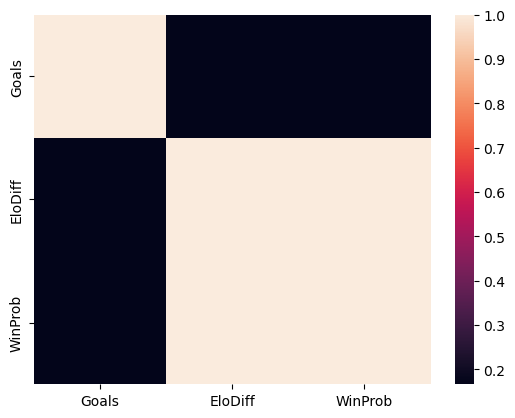

In [15]:
sns.heatmap(goals_elo_df.corr(numeric_only=True))
goals_elo_df.corr(numeric_only=True)[goals_elo_df.corr(numeric_only=True).abs() > 0.1]

In [16]:
def make_models():
  """Makes a dictionary of four untrained models"""

  return {
      'LR': LinearRegression(),
      'LR_L1':LassoCV(),
      'LR_L2':RidgeCV(),
      'CART': DecisionTreeRegressor(max_depth = 5, random_state=0),
      'RF': RandomForestRegressor(max_depth = 5, random_state=0),
  }

In [17]:
'''Create a data frame to keep track of all the models we train in this lab'''

# Initialize a tuple of names for each model
model_names = ('LR',  # Linear regression
               'LR_L1',
               'LR_L2',
               'CART',  # CART tree classifier
               'RF', # Random forest classifier
               'Poisson',
               'Beta',
               )

# Initialize a tuple of technique names that we will cover
engineering_techniques = ('Baseline', 'EloDiff Only', 'WinProb Only')

# Initialize the multi indices of the `all_models` data frame
df_indices = pd.MultiIndex.from_product([model_names, engineering_techniques], names=('model names', 'technique'))
# Initialize the `all_models` data frame
all_models = pd.DataFrame(index=df_indices, columns=['Train R2', 'Test R2', 'MSE', 'RMSE', 'MAE', 'Model'])
all_models[['Train R2']] = all_models[['Train R2']].astype(float)
all_models[['Test R2']] = all_models[['Test R2']].astype(float)
all_models  # Initialized data frame only has NaNs, which is perfect!

Train R2  Test R2  MSE RMSE  MAE Model
model names technique                                           
LR          Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
LR_L1       Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
LR_L2       Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
CART        Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
RF          Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
Poisson     Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
Beta        Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
XG Boost    Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN

In [20]:
X_train, X_test, y_train, y_test = train_test_split(goals_elo_df.drop(columns='Goals', axis=1), goals_elo_df['Goals'], test_size=0.30, random_state=1)

In [21]:
def fit_and_score_model(all_models, stage_name, X_train, X_out_of_sample, y_train, y_out_of_sample):
    """Fits the models that are initialized by models_dict on the X_train and y_train
    data, and evaluates the model on the out-of-sample data X_out_of_sample and y_out_of_sample"""

    # Make a dictionary of models
    models_dict = make_models()

    # Loop through each model in model_dict
    for model_name in models_dict:
        model = models_dict[model_name]

        '''Write some code to fit the model, and calculate precision (call it
        model_precision), recall (call it model_recall), and score (call it
        model_score) on the testing set.'''

        # Write your code here.
        # -------------------------------------------------------------------------
        model.fit(X_train, y_train)  # fit the model

        predicted_scores_train = model.predict(X_train)
        predicted_scores = model.predict(X_out_of_sample)

        r2_train = r2_score(y_train, predicted_scores_train)
        r2_test = r2_score(y_out_of_sample, predicted_scores)
        mse = mean_squared_error(y_out_of_sample, predicted_scores)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_out_of_sample, predicted_scores)

        train_score = model.score(X_train, y_train)
        test_score = model.score(X_out_of_sample, y_out_of_sample)

        # -------------------------------------------------------------------------
        print(f'{model_name} achieved a train score of {train_score:.3f} and test score of {test_score:.3f}')

        all_models.loc[model_name, stage_name] = np.array((r2_train, r2_test, mse, rmse, mae, model), dtype='object')

    return all_models

all_models = fit_and_score_model(all_models, 'Baseline', X_train, X_test, y_train, y_test)
all_models.loc[:, 'Baseline', :].head()

LR achieved a train score of 0.028 and test score of 0.027
LR_L1 achieved a train score of 0.028 and test score of 0.027
LR_L2 achieved a train score of 0.028 and test score of 0.027
CART achieved a train score of 0.033 and test score of 0.022
RF achieved a train score of 0.035 and test score of 0.026


,Train R2,Test R2,MSE,RMSE,MAE,Model
model names,,,,,,
LR,0.028216,0.026651,2.687626,1.639398,1.322685,LinearRegression()
LR_L1,0.028144,0.026731,2.687406,1.639331,1.323164,LassoCV()
LR_L2,0.028213,0.026678,2.687552,1.639376,1.322776,RidgeCV()
CART,0.032731,0.022425,2.699296,1.642954,1.327657,"DecisionTreeRegressor(max_depth=5, random_stat..."
RF,0.035484,0.026069,2.689234,1.639888,1.325284,"(DecisionTreeRegressor(max_depth=5, max_featur..."


### Choosing Parameter

In [271]:
from sklearn.model_selection import cross_validate

# Initialize cross validation score DataFrame
n_estimators = 1
n_estimators_ub = 100
cv_scores = pd.Series(index=np.arange(n_estimators, n_estimators_ub), dtype=float)

for numb_trees in range(n_estimators, n_estimators_ub):

  # Initialize the model
  rf_cv1_model = RandomForestRegressor(random_state = 0, max_depth = 5,
                          n_estimators = numb_trees, max_samples=0.2)

  # Run cross validation to get measure of out-of-sample error
  example_cv_results = cross_validate(rf_cv1_model, X_train, y_train, cv=5)

  # Record the average out-of-sample error
  cv_scores.loc[numb_trees] = example_cv_results['test_score'].mean()

print("Completed")

KeyboardInterrupt: 

In [ ]:
best_tree = cv_scores.idxmax()

for numb_trees in range(n_estimators, n_estimators_ub):
  plt.scatter(numb_trees, cv_scores.loc[numb_trees], c='blue')

print(f'The best max_depth parameter is {best_tree}. We would have chose max_depth = 5 without\ncross validation, which turns out to be slightly worse.')

plt.xlabel('Max Depth')  # lable for x axis
plt.ylabel('Score')  # lable for y axis
plt.show()

### Trying Poisson Models

In [382]:
X_train, X_test, y_train, y_test = train_test_split(new_goals_elo_df.drop(columns='Goals', axis=1), new_goals_elo_df['Goals'], test_size=0.30, random_state=1)

In [383]:
def poisson_model(pmodel, all_models, stage_name, X_train, X_out_of_sample, y_train, y_out_of_sample):
    """Fits the models that are initialized by models_dict on the X_train and y_train
    data, and evaluates the model on the out-of-sample data X_out_of_sample and y_out_of_sample"""

    predicted_scores_train = pmodel.predict(X_train)
    predicted_scores = pmodel.predict(X_out_of_sample)

    r2_train = r2_score(y_train, predicted_scores_train)
    r2_test = r2_score(y_out_of_sample, predicted_scores)
    mse = mean_squared_error(y_out_of_sample, predicted_scores)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_out_of_sample, predicted_scores)

    print(f'Log-likelihood is {pmodel.llf}')
    
    all_models.loc['Poisson', stage_name] = np.array((r2_train, r2_test, mse, rmse, mae, pmodel), dtype='object')

    return all_models

p_model1 = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
all_models = poisson_model(p_model1, all_models, 'Baseline', X_train, X_test, y_train, y_test)

Log-likelihood is -70249.14929160406


### Feature Selection

In [384]:
X_train, X_test, y_train, y_test = train_test_split(goals_elo_df.drop(columns=['Goals','WinProb'], axis=1), goals_elo_df['Goals'], test_size=0.30, random_state=5)
all_models = fit_and_score_model(all_models, 'EloDiff Only', X_train, X_test, y_train, y_test)
p_model2 = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
all_models = poisson_model(p_model2, all_models, 'EloDiff Only', X_train, X_test, y_train, y_test)
all_models.loc[:, 'EloDiff Only', :].head()

LR achieved a train score of 0.028 and test score of 0.026
LR_L1 achieved a train score of 0.028 and test score of 0.026
LR_L2 achieved a train score of 0.028 and test score of 0.026
CART achieved a train score of 0.033 and test score of 0.024
RF achieved a train score of 0.036 and test score of 0.025
Log-likelihood is -110161.52395759731


,Train R2,Test R2,MSE,RMSE,MAE,Model
model names,,,,,,
LR,0.028341,0.026233,2.714763,1.647654,1.321833,LinearRegression()
LR_L1,0.028341,0.026235,2.714757,1.647652,1.321827,LassoCV()
LR_L2,0.028341,0.026233,2.714763,1.647654,1.321833,RidgeCV()
CART,0.033444,0.023619,2.72205,1.649864,1.325277,"DecisionTreeRegressor(max_depth=5, random_stat..."
RF,0.035860,0.025414,2.717046,1.648346,1.32415,"(DecisionTreeRegressor(max_depth=5, max_featur..."


In [385]:
X_train, X_test, y_train, y_test = train_test_split(goals_elo_df.drop(columns=['Goals','EloDiff'], axis=1), goals_elo_df['Goals'], test_size=0.30, random_state=5)
all_models = fit_and_score_model(all_models, 'WinProb Only', X_train, X_test, y_train, y_test)
p_model3 = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
all_models = poisson_model(p_model3, all_models, 'WinProb Only', X_train, X_test, y_train, y_test)
all_models.loc[:, 'WinProb Only', :].head()

LR achieved a train score of 0.028 and test score of 0.026
LR_L1 achieved a train score of 0.028 and test score of 0.026
LR_L2 achieved a train score of 0.028 and test score of 0.026
CART achieved a train score of 0.033 and test score of 0.024
RF achieved a train score of 0.036 and test score of 0.025
Log-likelihood is -70223.32248529216


,Train R2,Test R2,MSE,RMSE,MAE,Model
model names,,,,,,
LR,0.028256,0.026159,2.714969,1.647716,1.322221,LinearRegression()
LR_L1,0.028256,0.026161,2.714963,1.647714,1.322215,LassoCV()
LR_L2,0.028256,0.026160,2.714967,1.647716,1.32222,RidgeCV()
CART,0.033444,0.023619,2.72205,1.649864,1.325277,"DecisionTreeRegressor(max_depth=5, random_stat..."
RF,0.035860,0.025429,2.717004,1.648334,1.32414,"(DecisionTreeRegressor(max_depth=5, max_featur..."


In [435]:
from sklearn.feature_selection import SelectKBest, f_classif

features = SelectKBest(score_func=f_classif, k=1).fit(X_train, y_train).get_feature_names_out()
features

array(['WinProbHome'], dtype=object)

In [387]:
all_models

Train R2   Test R2       MSE      RMSE       MAE  \
model names technique                                                        
LR          Baseline      0.028216  0.026651  2.687626  1.639398  1.322685   
            EloDiff Only  0.028341  0.026233  2.714763  1.647654  1.321833   
            WinProb Only  0.028256  0.026159  2.714969  1.647716  1.322221   
LR_L1       Baseline      0.028144  0.026731  2.687406  1.639331  1.323164   
            EloDiff Only  0.028341  0.026235  2.714757  1.647652  1.321827   
            WinProb Only  0.028256  0.026161  2.714963  1.647714  1.322215   
LR_L2       Baseline      0.028213  0.026678  2.687552  1.639376  1.322776   
            EloDiff Only  0.028341  0.026233  2.714763  1.647654  1.321833   
            WinProb Only  0.028256  0.026160  2.714967  1.647716   1.32222   
CART        Baseline      0.032731  0.022425  2.699296  1.642954  1.327657   
            EloDiff Only  0.033444  0.023619   2.72205  1.649864  1.325277   
            WinProb Only  0.033444  0.023619   2.72205  1.649864  1.325277   
RF          Baseline      0.035484  0.026069  2.689234  1.639888  1.325284   
            EloDiff Only  0.035860  0.025414  2.717046  1.648346   1.32415   
            WinProb Only  0.035860  0.025429  2.717004  1.648334   1.32414   
Poisson     Baseline     -0.010352 -0.013603  2.798777  1.672955  1.344026   
            EloDiff Only -1.147427 -1.161361  6.025653  2.454721  1.970255   
            WinProb Only -0.009327 -0.015120  2.830052  1.682276  1.341456   
Beta        Baseline           NaN       NaN       NaN       NaN       NaN   
            EloDiff Only       NaN       NaN       NaN       NaN       NaN   
            WinProb Only       NaN       NaN       NaN       NaN       NaN   
XG Boost    Baseline           NaN       NaN       NaN       NaN       NaN   
            EloDiff Only       NaN       NaN       NaN       NaN       NaN   
            WinProb Only       NaN       NaN       NaN       NaN       NaN   

                                                                      Model  
model names technique                                                        
LR          Baseline                                     LinearRegression()  
            EloDiff Only                                 LinearRegression()  
            WinProb Only                                 LinearRegression()  
LR_L1       Baseline                                              LassoCV()  
            EloDiff Only                                          LassoCV()  
            WinProb Only                                          LassoCV()  
LR_L2       Baseline                                              RidgeCV()  
            EloDiff Only                                          RidgeCV()  
            WinProb Only                                          RidgeCV()  
CART        Baseline      DecisionTreeRegressor(max_depth=5, random_stat...  
            EloDiff Only  DecisionTreeRegressor(max_depth=5, random_stat...  
            WinProb Only  DecisionTreeRegressor(max_depth=5, random_stat...  
RF          Baseline      (DecisionTreeRegressor(max_depth=5, max_featur...  
            EloDiff Only  (DecisionTreeRegressor(max_depth=5, max_featur...  
            WinProb Only  (DecisionTreeRegressor(max_depth=5, max_featur...  
Poisson     Baseline      <statsmodels.genmod.generalized_linear_model.G...  
            EloDiff Only  <statsmodels.genmod.generalized_linear_model.G...  
            WinProb Only  <statsmodels.genmod.generalized_linear_model.G...  
Beta        Baseline                                                    NaN  
            EloDiff Only                                                NaN  
            WinProb Only                                                NaN  
XG Boost    Baseline                                                    NaN  
            EloDiff Only                                                NaN  
            WinProb Only                       

## Beta Regression

In [388]:
X_train, X_test, y_train, y_test = train_test_split(goals_elo_df.drop(columns=['Goals','EloDiff'], axis=1), goals_elo_df['Goals'], test_size=0.30, random_state=5)

model = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Binomial()).fit()

# Predict goals
predicted_scores = model.predict(sm.add_constant(X_test))
predicted_scores_train = model.predict(sm.add_constant(X_train))

# Calculate evaluation metrics
r2_train = r2_score(y_train, predicted_scores_train)
r2_test = r2_score(y_test, predicted_scores)

mae = mean_absolute_error(y_test, predicted_scores)
mse = mean_squared_error(y_test, predicted_scores)
rmse = np.sqrt(mse)

all_models.loc['Beta', 'WinProb Only'] = np.array((r2_train, r2_test, mse, rmse, mae, model), dtype='object')
all_models

Train R2   Test R2       MSE      RMSE       MAE  \
model names technique                                                        
LR          Baseline      0.028216  0.026651  2.687626  1.639398  1.322685   
            EloDiff Only  0.028341  0.026233  2.714763  1.647654  1.321833   
            WinProb Only  0.028256  0.026159  2.714969  1.647716  1.322221   
LR_L1       Baseline      0.028144  0.026731  2.687406  1.639331  1.323164   
            EloDiff Only  0.028341  0.026235  2.714757  1.647652  1.321827   
            WinProb Only  0.028256  0.026161  2.714963  1.647714  1.322215   
LR_L2       Baseline      0.028213  0.026678  2.687552  1.639376  1.322776   
            EloDiff Only  0.028341  0.026233  2.714763  1.647654  1.321833   
            WinProb Only  0.028256  0.026160  2.714967  1.647716   1.32222   
CART        Baseline      0.032731  0.022425  2.699296  1.642954  1.327657   
            EloDiff Only  0.033444  0.023619   2.72205  1.649864  1.325277   
            WinProb Only  0.033444  0.023619   2.72205  1.649864  1.325277   
RF          Baseline      0.035484  0.026069  2.689234  1.639888  1.325284   
            EloDiff Only  0.035860  0.025414  2.717046  1.648346   1.32415   
            WinProb Only  0.035860  0.025429  2.717004  1.648334   1.32414   
Poisson     Baseline     -0.010352 -0.013603  2.798777  1.672955  1.344026   
            EloDiff Only -1.147427 -1.161361  6.025653  2.454721  1.970255   
            WinProb Only -0.009327 -0.015120  2.830052  1.682276  1.341456   
Beta        Baseline           NaN       NaN       NaN       NaN       NaN   
            EloDiff Only       NaN       NaN       NaN       NaN       NaN   
            WinProb Only -1.226085 -1.237898  6.239031  2.497805  1.980472   
XG Boost    Baseline           NaN       NaN       NaN       NaN       NaN   
            EloDiff Only       NaN       NaN       NaN       NaN       NaN   
            WinProb Only       NaN       NaN       NaN       NaN       NaN   

                                                                      Model  
model names technique                                                        
LR          Baseline                                     LinearRegression()  
            EloDiff Only                                 LinearRegression()  
            WinProb Only                                 LinearRegression()  
LR_L1       Baseline                                              LassoCV()  
            EloDiff Only                                          LassoCV()  
            WinProb Only                                          LassoCV()  
LR_L2       Baseline                                              RidgeCV()  
            EloDiff Only                                          RidgeCV()  
            WinProb Only                                          RidgeCV()  
CART        Baseline      DecisionTreeRegressor(max_depth=5, random_stat...  
            EloDiff Only  DecisionTreeRegressor(max_depth=5, random_stat...  
            WinProb Only  DecisionTreeRegressor(max_depth=5, random_stat...  
RF          Baseline      (DecisionTreeRegressor(max_depth=5, max_featur...  
            EloDiff Only  (DecisionTreeRegressor(max_depth=5, max_featur...  
            WinProb Only  (DecisionTreeRegressor(max_depth=5, max_featur...  
Poisson     Baseline      <statsmodels.genmod.generalized_linear_model.G...  
            EloDiff Only  <statsmodels.genmod.generalized_linear_model.G...  
            WinProb Only  <statsmodels.genmod.generalized_linear_model.G...  
Beta        Baseline                                                    NaN  
            EloDiff Only                                                NaN  
            WinProb Only  <statsmodels.genmod.generalized_linear_model.G...  
XG Boost    Baseline                                                    NaN  
            EloDiff Only                                                NaN  
            WinProb Only                       

## Seperate Poisson Investigation

In [182]:
import statsmodels.api as sm

# Fit a Poisson regression model to predict the scores
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# Predict scores for a specific game
predicted_scores = poisson_model.predict(X_test)

poisson_model.summary()

The R2 value is: -0.01360306622381624


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Goals   No. Observations:                36800
Model:                            GLM   Df Residuals:                    36799
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -70249.
Date:                Wed, 25 Oct 2023   Deviance:                       41184.
Time:                        17:06:33   Pearson chi2:                 3.87e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           -0.01404
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WinProb        2.0002      0.006    341.343      0.000       1.989       2.012
==============================================================================
"""

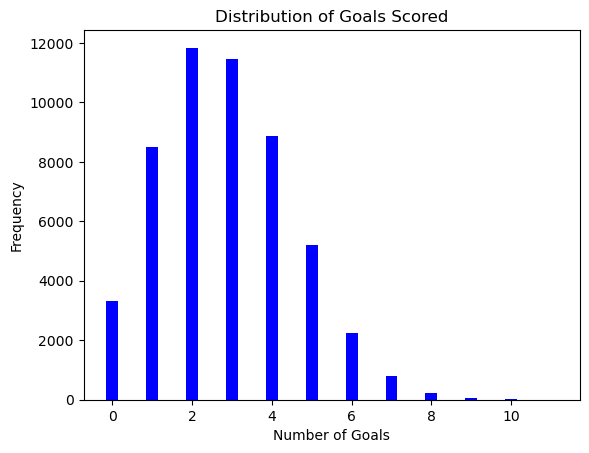

In [351]:
# Plot a histogram
bins = range(int(min(goals_elo_df['Goals'])), int(max(goals_elo_df['Goals'])) + 1)

plt.hist(goals_elo_df['Goals'], color='blue', bins = bins, align = 'left', rwidth = 0.3)
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.title('Distribution of Goals Scored')
plt.show()

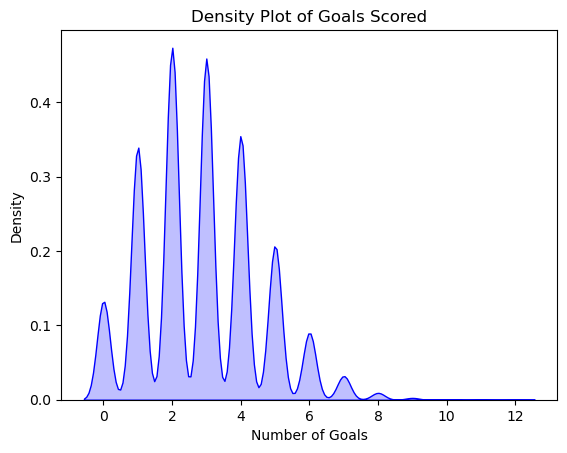

In [355]:
# Create a density plot
sns.kdeplot((goals_elo_df['Goals']), color='blue', shade=True)
plt.xlabel('Number of Goals')
plt.ylabel('Density')
plt.title('Density Plot of Goals Scored')
plt.show()

In [404]:
X_train, X_test, y_train, y_test = train_test_split(goals_elo_df.drop(columns=['Goals','EloDiff'], axis=1), goals_elo_df['Goals'], test_size=0.30, random_state=5)

Train score of 0.028 and test score of 0.026


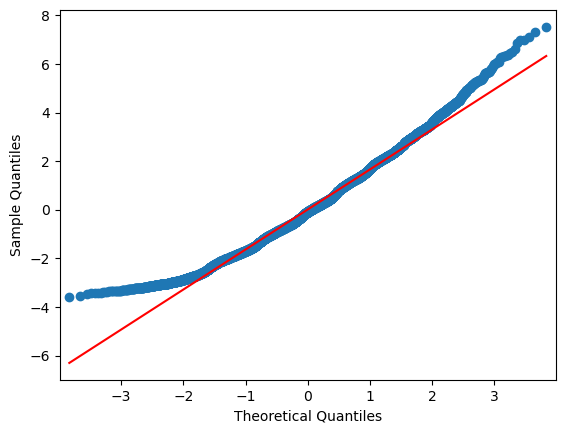

In [405]:
import statsmodels.api as sm
import pylab

def residual_plot(X_train, y_train, X_test, y_test):

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)  # fit the model

    predicted_scores = linreg.predict(X_test)
    residuals = y_test - predicted_scores

    train_score = linreg.score(X_train, y_train)
    test_score = linreg.score(X_test, y_test)

     # -------------------------------------------------------------------------
    print(f'Train score of {train_score:.3f} and test score of {test_score:.3f}')

    # Create a Q-Q plot
    sm.qqplot(residuals, line='s')
    pylab.show()

residual_plot(X_train, y_train, X_test, y_test)

Train score of 0.027 and test score of 0.025


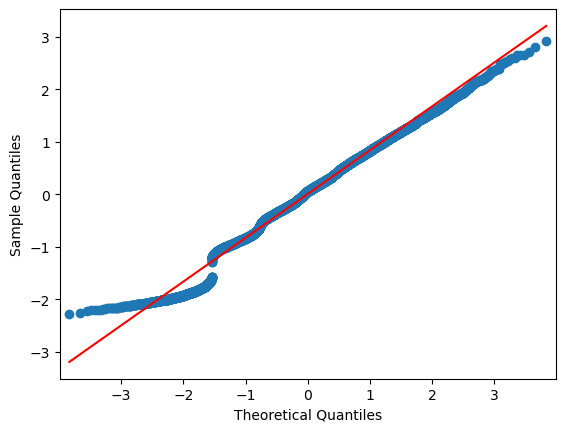

In [406]:
import scipy.stats as stats
goals_elo_df_c = goals_elo_df.copy()

# Your target variable (replace 'goals' with your actual variable)
target_variable = goals_elo_df_c['Goals']

# Add a small constant to avoid taking the log of zero
transformed_variable = np.power(target_variable, 2/3)

goals_elo_df_c['Goals'] = transformed_variable

X_train, X_test, y_train, y_test = train_test_split(goals_elo_df_c.drop(columns=['Goals','EloDiff'], axis=1), goals_elo_df_c['Goals'], test_size=0.30, random_state=5)

residual_plot(X_train, y_train, X_test, y_test)

In [ ]:
# Create a Q-Q plot for the original variable
stats.probplot(target_variable, dist='norm', plot=plt)
plt.title('Q-Q Plot for Original Variable')
plt.show()

# Create a Q-Q plot for the transformed variable
stats.probplot(transformed_variable, dist='norm', plot=plt)
plt.title('Q-Q Plot for Transformed Variable')
plt.show()

## Standardized Dependent Variable

Train score of 0.028 and test score of 0.026


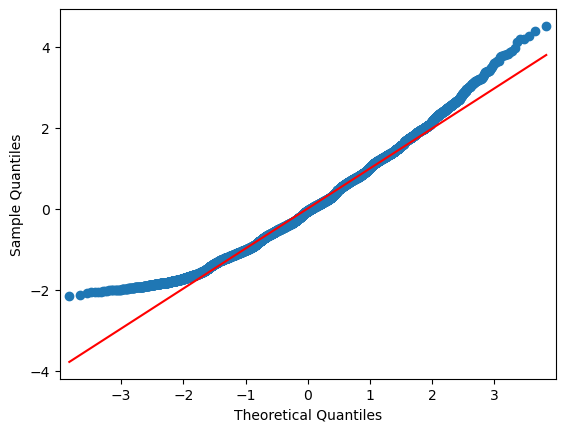

In [410]:
from sklearn.preprocessing import StandardScaler
goals_elo_df_c = goals_elo_df.copy()

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to your data and transform it
centered_data = scaler.fit_transform(goals_elo_df_c[['Goals']])

goals_elo_df_c['Goals'] = centered_data

X_train, X_test, y_train, y_test = train_test_split(goals_elo_df_c.drop(columns=['Goals','EloDiff'], axis=1), goals_elo_df_c['Goals'], test_size=0.30, random_state=5)

residual_plot(X_train, y_train, X_test, y_test)

## Goal Diff

In [425]:
goal_df = scores_dict.copy()
goal_df['Goal Diff'] = (goal_df['G_Home'] - goal_df['G_Vis'])
goal_df = goal_df[['Goal Diff','EloDiffHome','WinProbHome']]
goal_df

,Goal Diff,EloDiffHome,WinProbHome
0,0.0,50.000000,0.571463
1,0.0,50.000000,0.571463
2,2.0,50.000000,0.571463
3,-1.0,50.000000,0.571463
4,3.0,50.000000,0.571463
...,...,...,...
26281,-2.0,20.538435,0.529523
26282,5.0,141.001172,0.692465
26283,-1.0,-2.812827,0.495952
26284,-3.0,-39.207233,0.443815


In [427]:
X_train, X_test, y_train, y_test = train_test_split(goal_df.drop(['Goal Diff', 'WinProbHome'], axis = 1), goal_df['Goal Diff'], test_size=0.30, random_state=5)

In [428]:
'''Create a data frame to keep track of all the models we train in this lab'''

# Initialize a tuple of names for each model
model_names = ('LR',  # Linear regression
               'LR_L1',
               'LR_L2',
               'CART',  # CART tree classifier
               'RF', # Random forest classifier
               'Poisson',
               'Beta',
               'XG Boost'
               )

# Initialize a tuple of technique names that we will cover
engineering_techniques = ('Baseline', 'EloDiff Only', 'WinProb Only')

# Initialize the multi indices of the `all_models` data frame
df_indices = pd.MultiIndex.from_product([model_names, engineering_techniques], names=('model names', 'technique'))
# Initialize the `all_models` data frame
all_models2 = pd.DataFrame(index=df_indices, columns=['Train R2', 'Test R2', 'MSE', 'RMSE', 'MAE', 'Model'])
all_models2[['Train R2']] = all_models2[['Train R2']].astype(float)
all_models2[['Test R2']] = all_models2[['Test R2']].astype(float)
all_models2  # Initialized data frame only has NaNs, which is perfect!

Train R2  Test R2  MSE RMSE  MAE Model
model names technique                                           
LR          Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
LR_L1       Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
LR_L2       Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
CART        Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
RF          Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
Poisson     Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
Beta        Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN
XG Boost    Baseline           NaN      NaN  NaN  NaN  NaN   NaN
            EloDiff Only       NaN      NaN  NaN  NaN  NaN   NaN
            WinProb Only       NaN      NaN  NaN  NaN  NaN   NaN

In [429]:
def fit_and_score_model(all_models2, stage_name, X_train, X_out_of_sample, y_train, y_out_of_sample):
    """Fits the models that are initialized by models_dict on the X_train and y_train
    data, and evaluates the model on the out-of-sample data X_out_of_sample and y_out_of_sample"""

    # Make a dictionary of models
    models_dict = make_models()

    # Loop through each model in model_dict
    for model_name in models_dict:
        model = models_dict[model_name]

        '''Write some code to fit the model, and calculate precision (call it
        model_precision), recall (call it model_recall), and score (call it
        model_score) on the testing set.'''

        # Write your code here.
        # -------------------------------------------------------------------------
        model.fit(X_train, y_train)  # fit the model

        predicted_scores_train = model.predict(X_train)
        predicted_scores = model.predict(X_out_of_sample)

        r2_train = r2_score(y_train, predicted_scores_train)
        r2_test = r2_score(y_out_of_sample, predicted_scores)
        mse = mean_squared_error(y_out_of_sample, predicted_scores)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_out_of_sample, predicted_scores)

        train_score = model.score(X_train, y_train)
        test_score = model.score(X_out_of_sample, y_out_of_sample)

        # -------------------------------------------------------------------------
        print(f'{model_name} achieved a train score of {train_score:.3f} and test score of {test_score:.3f}')

        all_models2.loc[model_name, stage_name] = np.array((r2_train, r2_test, mse, rmse, mae, model), dtype='object')

    return all_models2

all_models2 = fit_and_score_model(all_models2, 'EloDiff Only', X_train, X_test, y_train, y_test)
all_models2.loc[:, 'EloDiff Only', :].head()

LR achieved a train score of 0.044 and test score of 0.037
LR_L1 achieved a train score of 0.044 and test score of 0.037
LR_L2 achieved a train score of 0.044 and test score of 0.037
CART achieved a train score of 0.052 and test score of 0.030
RF achieved a train score of 0.056 and test score of 0.036


,Train R2,Test R2,MSE,RMSE,MAE,Model
model names,,,,,,
LR,0.044206,0.037177,5.599961,2.366424,1.956872,LinearRegression()
LR_L1,0.044206,0.037186,5.599913,2.366414,1.956908,LassoCV()
LR_L2,0.044206,0.037177,5.599961,2.366424,1.956872,RidgeCV()
CART,0.051515,0.029823,5.642734,2.375444,1.961076,"DecisionTreeRegressor(max_depth=5, random_stat..."
RF,0.056090,0.035783,5.60807,2.368136,1.957814,"(DecisionTreeRegressor(max_depth=5, max_featur..."


In [432]:
X_train, X_test, y_train, y_test = train_test_split(goal_df.drop(columns=['Goal Diff','EloDiffHome'], axis=1), goal_df['Goal Diff'], test_size=0.30, random_state=5)
all_models2 = fit_and_score_model(all_models, 'WinProb Only', X_train, X_test, y_train, y_test)
all_models2.loc[:, 'WinProb Only', :].head() 

LR achieved a train score of 0.044 and test score of 0.037
LR_L1 achieved a train score of 0.044 and test score of 0.037
LR_L2 achieved a train score of 0.044 and test score of 0.037
CART achieved a train score of 0.052 and test score of 0.030
RF achieved a train score of 0.056 and test score of 0.036


,Train R2,Test R2,MSE,RMSE,MAE,Model
model names,,,,,,
LR,0.044115,0.037256,5.599502,2.366327,1.95535,LinearRegression()
LR_L1,0.044115,0.037264,5.599456,2.366317,1.955389,LassoCV()
LR_L2,0.044115,0.037263,5.599466,2.366319,1.955381,RidgeCV()
CART,0.051515,0.029823,5.642734,2.375444,1.961076,"DecisionTreeRegressor(max_depth=5, random_stat..."
RF,0.056091,0.035789,5.608038,2.36813,1.957814,"(DecisionTreeRegressor(max_depth=5, max_featur..."


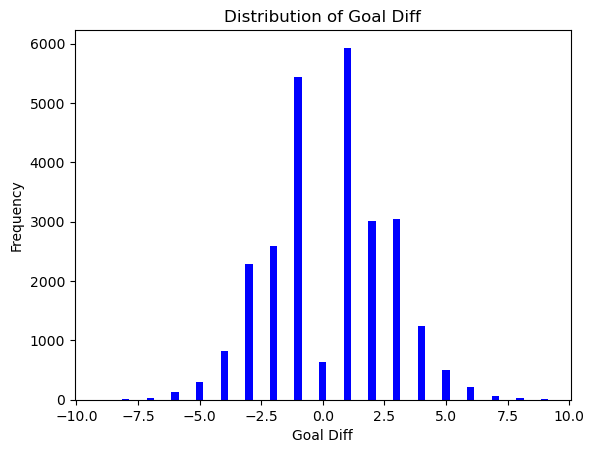

In [433]:
# Plot a histogram
bins = range(int(min(goal_df['Goal Diff'])), int(max(goal_df['Goal Diff'])) + 1)

plt.hist(goal_df['Goal Diff'], color='blue', bins = bins, align = 'left', rwidth = 0.3)
plt.xlabel('Goal Diff')
plt.ylabel('Frequency')
plt.title('Distribution of Goal Diff')
plt.show()